# Computation of persistence homology from the signals using HomCloud

This tutorial provides instructions for how to perform persistent homology and generate persistent diagrams from the signals of 3D CUBIC image data using HomCloud. HomCloud is a data analysis software based on persistent homology developed by [Obayashi, Nakamura, and Hirooka (2022)](https://journals.jps.jp/doi/10.7566/JPSJ.91.091013).

## Download signal files

This tutorial uses classified files as lymphatic vessels in the lung fibrosis model using bleomysin which was described in Figure 6 of Takahashi et al. (2022).
**Note**: See this notebook for a tutorial on how to extract the signals from 3D CUBIC data.

In [17]:
T1 <- Sys.time()
system("wget https://www.dropbox.com/s/o7t2ynawftqdahc/tutorial_ph_data.zip")
system("unzip /content/tutorial_ph_data.zip")
T2 <- Sys.time()
T2 - T1

Time difference of 8.957582 secs

## Install HomCloud

Install HomCloud for performing persistent homology.

In [ ]:
T1 <- Sys.time()
system("apt-get install libcgal-dev cmake")
system("pip install forwardable imageio Cython cached-property wheel")
system("pip install ripser")
system("pip install homcloud")
system("python3 -m homcloud.self_check --no-dipha --no-paraview")
T2 <- Sys.time()
T2 - T1

Time difference of 17.82168 secs

Install the R packages including TDA and TDAstats for visualization of persistence diagrams

In [ ]:
T1 <- Sys.time()
install.packages("TDA")
install.packages("data.table")
install.packages("TDAstats")
install.packages("gridExtra")
library(data.table)
library(TDA)
library(TDAstats)
library(tidyverse)
library(gridExtra)
T2 <- Sys.time()
T2 - T1

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




Time difference of 3.39548 secs

## Reading the signal files, normalization, and random sampling

List the files in the directory and select the downloaded files.

In [18]:
T1 <- Sys.time()
signal_files <- list.files("/content/tutorial_ph_data",full.names=TRUE,pattern="_all_signal\\.csv$")
signal_files
T2 <- Sys.time()
T2 - T1

[1] "/content/tutorial_ph_data/bleomycin_160_lung_p70_all_signal.csv"
[2] "/content/tutorial_ph_data/bleomycin_190_lung_p70_all_signal.csv"
[3] "/content/tutorial_ph_data/bleomycin_203_lung_p50_all_signal.csv"
[4] "/content/tutorial_ph_data/bleomycin_205_lung_p70_all_signal.csv"
[5] "/content/tutorial_ph_data/bleomycin_225_lung_p70_all_signal.csv"
[6] "/content/tutorial_ph_data/bleomycin_257_lung_p70_all_signal.csv"
[7] "/content/tutorial_ph_data/control_140_lung_p50_all_signal.csv"  
[8] "/content/tutorial_ph_data/control_141_lung_p50_all_signal.csv"  
[9] "/content/tutorial_ph_data/control_197_lung_p70_all_signal.csv"

Time difference of 0.01279902 secs

Show the data structure and the first 6 rows of the extracted signal file.

In [20]:
T1 <- Sys.time()
x <- fread(signal_files[1],sep=",",header=TRUE)
head(x)
T2 <- Sys.time()
T2 - T1

ID,X,Y,Z,volume
<int>,<dbl>,<dbl>,<dbl>,<int>
1,1351,365,1,1
2,1351,366,1,1
3,1618,410,1,1
4,1563,328,2,1
5,1563,331,2,1
6,1563,332,2,1


Time difference of 0.08032346 secs

Normalize the x-, y-, and z-axis coordinates of the signal value so that the maximum is 1 and the minimum is 0. Randomly select 50,000 signal value data points due to the large sample size of the signal value data, and output the normalized coordinates as a input file of the next analysis.

In [21]:
T1 <- Sys.time()

my_scale <- function(x,maxx,minx){
  x <- (x - minx) / (maxx-minx)
  return(x)
}

maxx <- minx <- matrix(NA,length(signal_files),3)
for(i in 1:length(signal_files)){
  x <- fread(signal_files[i],sep=",",header=TRUE)
  x <- as.data.frame(x[,2:4])
  maxx[i,] <- apply(x,2,max)
  minx[i,] <- apply(x,2,min)
}
maxx <- apply(maxx,2,max)
minx <- apply(minx,2,min)

r <- 50000
infiles <- gsub("\\.csv","_50000\\.tsv",signal_files)

for(i in 1:length(signal_files)){
  x <- fread(signal_files[i],sep=",",header=TRUE)
  x <- as.data.frame(x[,2:4])
  x_norm <- matrix(0,nrow(x),3)
  for(j in 1:3) x_norm[,j] <- my_scale(x[,j],maxx[j],minx[j])
  n <- nrow(x)
  id <- 1:n
  set.seed(12345)
  if(n >= r){
    id <- sample(1:n,r)
  }
  xx <- x_norm[id,1:3]
  write.table(xx,infiles[i],sep=" ",
  row.names=FALSE,col.names=FALSE,quote=FALSE)
}

T2 <- Sys.time()
T2 - T1

Time difference of 13.15739 secs

## Performing persistent homology using HomCloud to generate persistence diagrams

In [22]:
T1 <- Sys.time()

outfiles1 <- gsub("\\.tsv","\\.pdgm",infiles)
outfiles2 <- gsub("\\.tsv","_pd1\\.tsv",infiles)
outfiles3 <- gsub("\\.tsv","_pd2\\.tsv",infiles)

for(i in 1:length(infiles)){
  command <- paste("python3 -m homcloud.pc_alpha -d 3",infiles[i],outfiles1[i])
  cat(command,"\n")
  try(system(command))

  command <- paste("python3 -m homcloud.dump_diagram -S no -d 1",outfiles1[i],"-o",outfiles2[i])
  cat(command,"\n")
  try(system(command))

  command <- paste("python3 -m homcloud.dump_diagram -S no -d 2",outfiles1[i],"-o",outfiles3[i])
  cat(command,"\n")
  try(system(command))
}

T2 <- Sys.time()
T2 - T1

python3 -m homcloud.pc_alpha -d 3 /content/tutorial_ph_data/bleomycin_160_lung_p70_all_signal_50000.tsv /content/tutorial_ph_data/bleomycin_160_lung_p70_all_signal_50000.pdgm 
python3 -m homcloud.dump_diagram -S no -d 1 /content/tutorial_ph_data/bleomycin_160_lung_p70_all_signal_50000.pdgm -o /content/tutorial_ph_data/bleomycin_160_lung_p70_all_signal_50000_pd1.tsv 
python3 -m homcloud.dump_diagram -S no -d 2 /content/tutorial_ph_data/bleomycin_160_lung_p70_all_signal_50000.pdgm -o /content/tutorial_ph_data/bleomycin_160_lung_p70_all_signal_50000_pd2.tsv 
python3 -m homcloud.pc_alpha -d 3 /content/tutorial_ph_data/bleomycin_190_lung_p70_all_signal_50000.tsv /content/tutorial_ph_data/bleomycin_190_lung_p70_all_signal_50000.pdgm 
python3 -m homcloud.dump_diagram -S no -d 1 /content/tutorial_ph_data/bleomycin_190_lung_p70_all_signal_50000.pdgm -o /content/tutorial_ph_data/bleomycin_190_lung_p70_all_signal_50000_pd1.tsv 
python3 -m homcloud.dump_diagram -S no -d 2 /content/tutorial_ph_data

Time difference of 3.83732 mins

## Plot of persistence diagram in lymphatic vessels in fibrosis model with intratracheal administration of bleomycin and control group

Persistent diagrams are shown in each sample.
The red points (dimention1) and blue triangles (dimention2) represent planar feature points (loop) and spatial feature points (void), respectively, observed by homCloud.


1 / 9 
2 / 9 
3 / 9 
4 / 9 
5 / 9 
6 / 9 
7 / 9 
8 / 9 
9 / 9 


TableGrob (3 x 3) "arrange": 9 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (1-1,3-3) arrange gtable[layout]
4 4 (2-2,1-1) arrange gtable[layout]
5 5 (2-2,2-2) arrange gtable[layout]
6 6 (2-2,3-3) arrange gtable[layout]
7 7 (3-3,1-1) arrange gtable[layout]
8 8 (3-3,2-2) arrange gtable[layout]
9 9 (3-3,3-3) arrange gtable[layout]

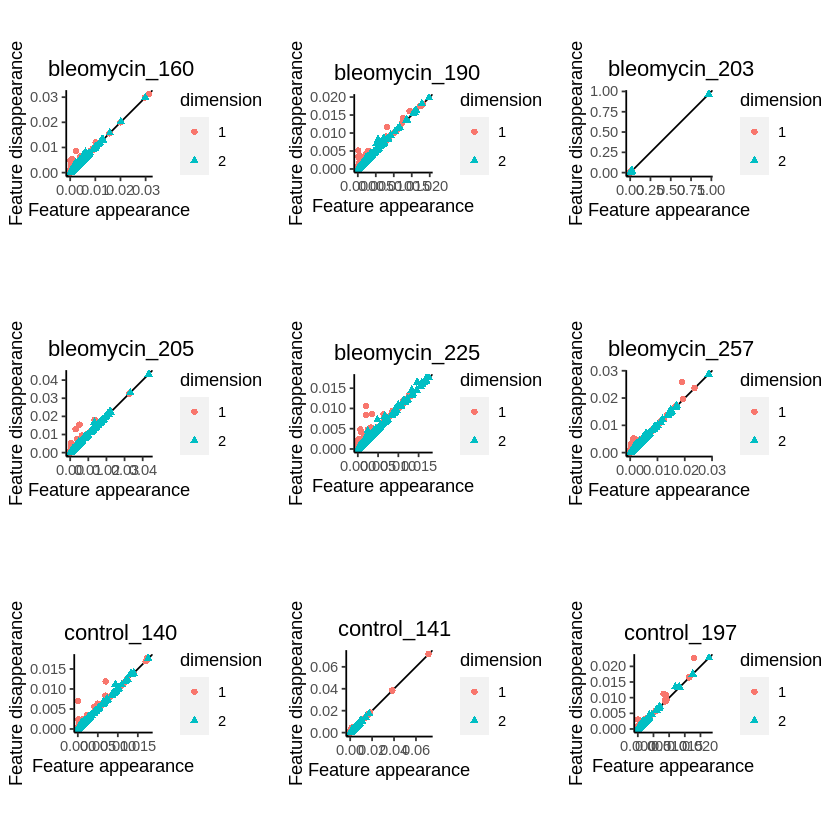

In [23]:
p <- vector("list",length(outfiles2))
filenames <- sapply(strsplit(basename(outfiles2),"_"),function(x){paste(x[1:2],collapse="_")})
for(i in 1:length(outfiles2)){
  cat(i,"/",length(outfiles2),"\n")
  junk <- rbind(cbind(1,as.matrix(fread(outfiles2[i],sep=" ",header=FALSE))),
                        cbind(2,as.matrix(fread(outfiles3[i],sep=" ",header=FALSE))))
  colnames(junk) <- c("dimension","birth","death")
  id <- which(junk[,2] < junk[,3])
  p[[i]] <- plot_persist(junk[id,]) + 
            ggtitle(filenames[i]) +
            theme(plot.title = element_text(hjust = 0.3))
}
pp <- grid.arrange(p[[1]], p[[2]], p[[3]], p[[4]], p[[5]],
p[[6]], p[[7]], p[[8]], p[[9]], nrow = 3)
pp